##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
# %pip install pandas 
# %pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
df = pd.read_parquet(filepath)
df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


# 1. Data Analysis (60%)

### 1.1 Data cleaning

##### Drop columns that have 100% missing values
Reason: Impossible to guess a column without any prexisting data for that column

In [4]:
cols_missing = df.columns[df.isnull().sum() > 0]
cols_missing_all = df.columns[df.isnull().sum() == df.shape[0]]
cols_missing_100 = cols_missing.intersection(cols_missing_all)
df.drop(cols_missing_100, axis=1, inplace=True)

##### Fill nan with zero

['f_ever_declined_la', 'recency_lapse', 'flg_affconnect_show_interest_ever',
'flg_affconnect_ready_to_buy_ever', 'clmcon_visit_days', 'hlthclaim_amt',
'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'giclaim_amt', 'f_purchase_lh']<br/>
Reason: Most of these are just binary fields, and it is logical to replace them with 0 if we see that only 1 is present
Another reason: Some of these columns are related to amount claim or purchase, which we assume that 0 means it is not relavent for them

In [5]:
def replace_missing_with_zero(df, column_name):
    df[column_name].fillna(0, inplace=True)
    return df


columns_to_replace_missing_with_zero = ['f_ever_declined_la', 'recency_lapse', 'flg_affconnect_show_interest_ever',
                                        'flg_affconnect_ready_to_buy_ever', 'clmcon_visit_days', 'hlthclaim_amt',
                                        'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'giclaim_amt', 'f_purchase_lh']

for i in columns_to_replace_missing_with_zero:
    df = replace_missing_with_zero(df, i)

##### Fill nan with one
is_dependent_in_at_least_1_policy <br/>
Reason: The distinct value for this col is 0, and the name suggests that it is a binary field, so we fill missing values with 1

In [6]:
def replace_missing_with_one(df, column_name):
    df[column_name].fillna(1, inplace=True)
    return df


columns_to_replace_missing_with_one = ['is_dependent_in_at_least_1_policy']

for i in columns_to_replace_missing_with_one:
    df = replace_missing_with_one(df, i)

##### Fill nan with median
'hh_20', 'pop_20', 'hh_size', 'annual_income_est' <br/>
Reason: They follow a roughly normal distribution data, so replacing with median seems logical here

In [7]:
# Fill nan with median
def replace_missing_with_median(df, column_name):
    median_value = df[column_name].median()
    df[column_name].fillna(median_value, inplace=True)
    return df

columns_to_replace_missing_with_median = [
    'hh_20', 'pop_20', 'hh_size']

for i in columns_to_replace_missing_with_median:
    df = replace_missing_with_median(df, i)

##### Fill missing values according to proportion of missing values in each column
'race_desc', 'cltsex_fix' <br/>
Reason: They only have a few missing values, so it is reasonable to fill up the missing ones according to the current data proportion

In [8]:
# Helper Functions
def value_proportions(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    total_count = arr.size
    proportions = counts / total_count
    return dict(zip(unique_values, proportions))


def fill_missing_with_proportions(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Get the non-missing values and their proportions
    non_missing_values = df[column_name].dropna()
    value_distribution = value_proportions(non_missing_values)

    # Convert the value distribution into two lists for np.random.choice
    values, probabilities = zip(*value_distribution.items())

    # Count the missing values
    missing_count = df[column_name].isna().sum()

    if missing_count > 0:
        # Generate random samples based on the value distribution
        random_samples = np.random.choice(
            values, size=missing_count, p=probabilities)

        # Fill in the missing values with these random samples
        df.loc[df[column_name].isna(), column_name] = random_samples

    return df

df = fill_missing_with_proportions(df, 'race_desc')
df = fill_missing_with_proportions(df, 'cltsex_fix')

##### Delete rows with continuous missing values about flg_* columns

In [9]:
# Helper Functions
def delete_rows_with_all_missing(df, columns_names):
    # Initial number of rows
    initial_row_count = len(df)

    # Drop rows where all values in the selected columns are missing
    df = df.dropna(subset=columns_names, how='all')

    # Calculate the number of rows deleted
    deleted_rows_count = initial_row_count - len(df)

    print(f"Deleted {deleted_rows_count} rows.")


    return df


SELECTED_FLG_COLUMNS = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
                        'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
                        'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation',
                        'flg_is_returned_mail']

df = delete_rows_with_all_missing(df, SELECTED_FLG_COLUMNS)
df.head()

Deleted 1014 rows.


,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_hlthclaim_success,hlthclaim_cnt_unsuccess,recency_hlthclaim_unsuccess,flg_hlthclaim_839f8a_ever,recency_hlthclaim_839f8a,flg_hlthclaim_14cb37_ever,recency_hlthclaim_14cb37,giclaim_amt,recency_giclaim,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0


In [10]:
# Shape after cleaning
df.shape

(16978, 296)

### 1.2 Feature Selection

Drop col 'clntnum' <br/>
Reason: This is just a unique identifier for each customer, which doesn't contribute much

In [11]:
df.drop('clntnum', axis=1, inplace=True)

##### Drop columns that have no missing values and one unique value
Reason: One  unique values doesnt really do much

In [12]:
cols_no_missing = df.columns[df.isnull().sum() == 0]
cols_one_unique = df.columns[df.nunique() == 1]
cols_to_drop = cols_no_missing.intersection(cols_one_unique)
df.drop(cols_to_drop, axis=1, inplace=True)

drop ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']<br/>
Reason: These are related to communication, and we don't think it contributes much

In [13]:
COMMUNICATION_PREFERENCE_COLS = [
    'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email'
]

df.drop(COMMUNICATION_PREFERENCE_COLS, axis=1, inplace=True)

drop ctrycode_desc <br/>
Reason: 99% of the data here is Singapore, which doesn't really contributes much information

drop hh_size_est <br/>
Reason: Already have hh_size, no need this

drop 'recency_cancel', 'tot_cancel_pols' <br/>
Reason: We believe that the information from recency lapse should be sufficient

drop 'n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis', 'recency_hlthclaim', 'recency_hlthclaim_success', 'recency_hlthclaim_unsuccess', 'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a', 'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb37', 'recency_giclaim'
<br /><br />Reason: All of these have too many missing values, and also some like flg_hlthclaim_14cb37_ever is related to a specific insurance which we decide to not focus for now

In [14]:
DROP_COLS = [
    'ctrycode_desc', 'hh_size_est', 'recency_cancel', 'tot_cancel_pols', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis',
    'recency_hlthclaim', 'recency_hlthclaim_success', 'recency_hlthclaim_unsuccess', 'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a', 'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb37',
    'recency_giclaim'
]

# Drop cols that are not needed
df.drop(DROP_COLS, axis=1, inplace=True)

drop 'lapse_ape_*' <br/>
Reason: We believe that the information from recency lapse should be sufficient

drop n_months_since_lapse_ <br/>
Reason: Since we drop all cols starting with 'lapse_ape_', all of n_months_since_lapse_ should be drop too since they relate to one another

drop cols 'f_hold_*', 'f_ever_bought_*' <br/>
Reason: Related to individual insurance that we decide not to focus for now

In [15]:
DROP_COLS_REGEX = ['lapse_ape_*', 'n_months_since_lapse_*',
                   'f_hold_*', 'f_ever_bought_*']

# Drop cols regex
cols_to_drop = df.columns[df.columns.str.contains('|'.join(DROP_COLS_REGEX))]
df.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
# Shape after feature selection
df.shape

(16978, 140)

### 1.3 Feature Engineering

##### Change 'annual_income_est' from string to integer

In [17]:
for index, row in df.iterrows():
    if row['annual_income_est'] == 'A.ABOVE200K':
        df.loc[index, 'annual_income_est'] = 200000
    elif row['annual_income_est'] == 'B.100K-200K':
        df.loc[index, 'annual_income_est'] = 150000
    elif row['annual_income_est'] == 'C.60K-100K':
        df.loc[index, 'annual_income_est'] = 80000
    elif row['annual_income_est'] == 'D.30K-60K':
        df.loc[index, 'annual_income_est'] = 45000
    elif row['annual_income_est'] == 'E.BELOW30K':
        df.loc[index, 'annual_income_est'] = 30000


# Fill nan of annual_income_est with median
df = replace_missing_with_median(df, 'annual_income_est')

##### Do One Hot Encoding for categorical variables

'clttype', 'stat_flag', 'race_desc', 'cltsex_fix' <br/>
Reason: They are categorical columns with not many distinct values, so one hot encoding can be used here

In [18]:
# Helper Functions
def find_col_index(df, col_name):
    return df.columns.get_loc(col_name)

def one_hot_encode(df, col, start_position=0):
    df_encoded = pd.get_dummies(df[col], prefix=col, dtype=int)
    df.drop(col, axis=1, inplace=True)
    df = pd.concat([df.iloc[:, :start_position], df_encoded,
                   df.iloc[:, start_position:]], axis=1)
    return df


# One hot encoding for 'clttype'
start_position = find_col_index(df, 'clttype')
df = one_hot_encode(df, 'clttype', start_position)

# One hot encoding for 'stat_flag'
start_position = find_col_index(df, 'stat_flag')
df = one_hot_encode(df, 'stat_flag', start_position)

# One hot encoding for 'race_desc'
start_position = find_col_index(df, 'race_desc')
df = one_hot_encode(df, 'race_desc', start_position)

# One hot encoding for 'cltsex_fix'
start_position = find_col_index(df, 'cltsex_fix')
df = one_hot_encode(df, 'cltsex_fix', start_position)

df.head()

,race_desc_Chinese,race_desc_Indian,race_desc_Malay,race_desc_Others,clttype_C,clttype_G,clttype_P,stat_flag_ACTIVE,stat_flag_LAPSED,stat_flag_MATURED,...,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,clmcon_visit_days,hlthclaim_amt,hlthclaim_cnt_success,hlthclaim_cnt_unsuccess,giclaim_amt,f_purchase_lh
19550,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
4600,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
13337,0,0,0,1,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
15074,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
19724,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0


##### Convert dates to years

'min_occ_date', 'cltdob_fix' <br/>
Reason: These are in dates, if we convert to years, they are only integers, which would be more compatible for the model to fit

In [19]:
def years_until_2024(df, column_name, target_year=2024):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Remove rows where the date column is "None"
    df = df[df[column_name] != "None"]

    # Strip the string of whitespace and convert to datetime using .loc
    df.loc[:, column_name] = pd.to_datetime(
        df[column_name].str.strip(), format='%Y-%m-%d', errors='raise')

    # Calculate the number of years until 2024 using .loc
    df.loc[:, column_name] = df[column_name].apply(
        lambda x: target_year - x.year if pd.notnull(x) else None)

    # Convert the column to integer data type
    df = df.astype({column_name: 'int64'})

    return df


df = years_until_2024(df, 'min_occ_date', 2024)
df = years_until_2024(df, 'cltdob_fix', 2024)
df.head()

,race_desc_Chinese,race_desc_Indian,race_desc_Malay,race_desc_Others,clttype_C,clttype_G,clttype_P,stat_flag_ACTIVE,stat_flag_LAPSED,stat_flag_MATURED,...,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,clmcon_visit_days,hlthclaim_amt,hlthclaim_cnt_success,hlthclaim_cnt_unsuccess,giclaim_amt,f_purchase_lh
19550,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
4600,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
13337,0,0,0,1,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
15074,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
19724,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0


##### Sum/Average columns of interest to create new column

'ape_', 'sumins_', 'prempaid_', 'n_months_' <br/>
Reason: Since they are related to various individual insurance, we decide to combine them for now with either summing or averaging(for months), to make it more simplified

In [20]:
# Helper Functions
def fetch_all_columns_with_prefix(df, prefix):
    # Get all the columns that start with the prefix
    cols_to_fetch = df.columns[df.columns.str.startswith(prefix)]

    return cols_to_fetch.tolist()


def sum_numeric_columns_prefix(df, prefix, new_column_name='sum', start_position=0):
    # Get all the columns that start with the prefix
    column_names = fetch_all_columns_with_prefix(df, prefix)

    # Convert columns to numeric
    for col in column_names:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='raise')
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Sum the columns
    df[new_column_name] = df[column_names].sum(axis=1)

    # Insert the new column at the specified start_position index
    df = pd.concat([df.iloc[:, :start_position],
                   df[new_column_name], df.iloc[:, start_position:-1]], axis=1)

    # Drop the original columns
    df = df.drop(column_names, axis=1)

    return df


def average_numeric_columns(df, prefix, new_columns_name='average', start_position=0):
    # Get all the columns that start with the prefix
    column_names = fetch_all_columns_with_prefix(df, prefix)

    # Convert columns to numeric
    for col in column_names:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='raise')
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Sum the columns
    df[new_columns_name] = df[column_names].mean(axis=1).round(2)

    # Insert the new column at the specified start_position index
    df = pd.concat([df.iloc[:, :start_position],
                   df[new_columns_name], df.iloc[:, start_position:-1]], axis=1)

    df = df.drop(column_names, axis=1)

    return df

# Sum the columns
start_position = find_col_index(
    df, fetch_all_columns_with_prefix(df, 'ape_')[0])
df = sum_numeric_columns_prefix(df, 'ape_', 'sum_ape', start_position)

start_position = find_col_index(
    df, fetch_all_columns_with_prefix(df, 'sumins_')[0])
df = sum_numeric_columns_prefix(df, 'sumins_', 'sum_sumins', start_position)

start_position = find_col_index(
    df, fetch_all_columns_with_prefix(df, 'prempaid_')[0])
df = sum_numeric_columns_prefix(
    df, 'prempaid_', 'sum_prempaid', start_position)

start_position = find_col_index(
    df, fetch_all_columns_with_prefix(df, 'n_months_')[0])
df = average_numeric_columns(df, 'n_months_', 'avg_n_months_', start_position)
df.head()

/var/folders/ms/9mlzst3s2vj4lsly34ghl8900000gn/T/ipykernel_55872/2958598700.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[column_names].sum(axis=1)


,race_desc_Chinese,race_desc_Indian,race_desc_Malay,race_desc_Others,clttype_C,clttype_G,clttype_P,stat_flag_ACTIVE,stat_flag_LAPSED,stat_flag_MATURED,...,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,clmcon_visit_days,hlthclaim_amt,hlthclaim_cnt_success,hlthclaim_cnt_unsuccess,giclaim_amt,f_purchase_lh
19550,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
4600,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
13337,0,0,0,1,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
15074,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0
19724,1,0,0,0,0,0,1,1,0,0,...,0,1,0.0,0.0,0.0,0,0.0,0.0,0,0.0


##### Check for columns that should be in int or float

In [21]:
# Print all columns that are not int or float
print("Columns that are not int or float")
print(df.select_dtypes(exclude=['int', 'float']).columns)

df = df.astype({'hh_20': 'int64', 'pop_20': 'int64',
               'hlthclaim_amt': 'float', 'giclaim_amt': 'float'})

Columns that are not int or float
Index(['hh_20', 'pop_20', 'hlthclaim_amt', 'giclaim_amt'], dtype='object')


### 1.4 Data Visualisation
Clarity, Relevance, Clustering Techniques, Aesthetics and Insightfulness.

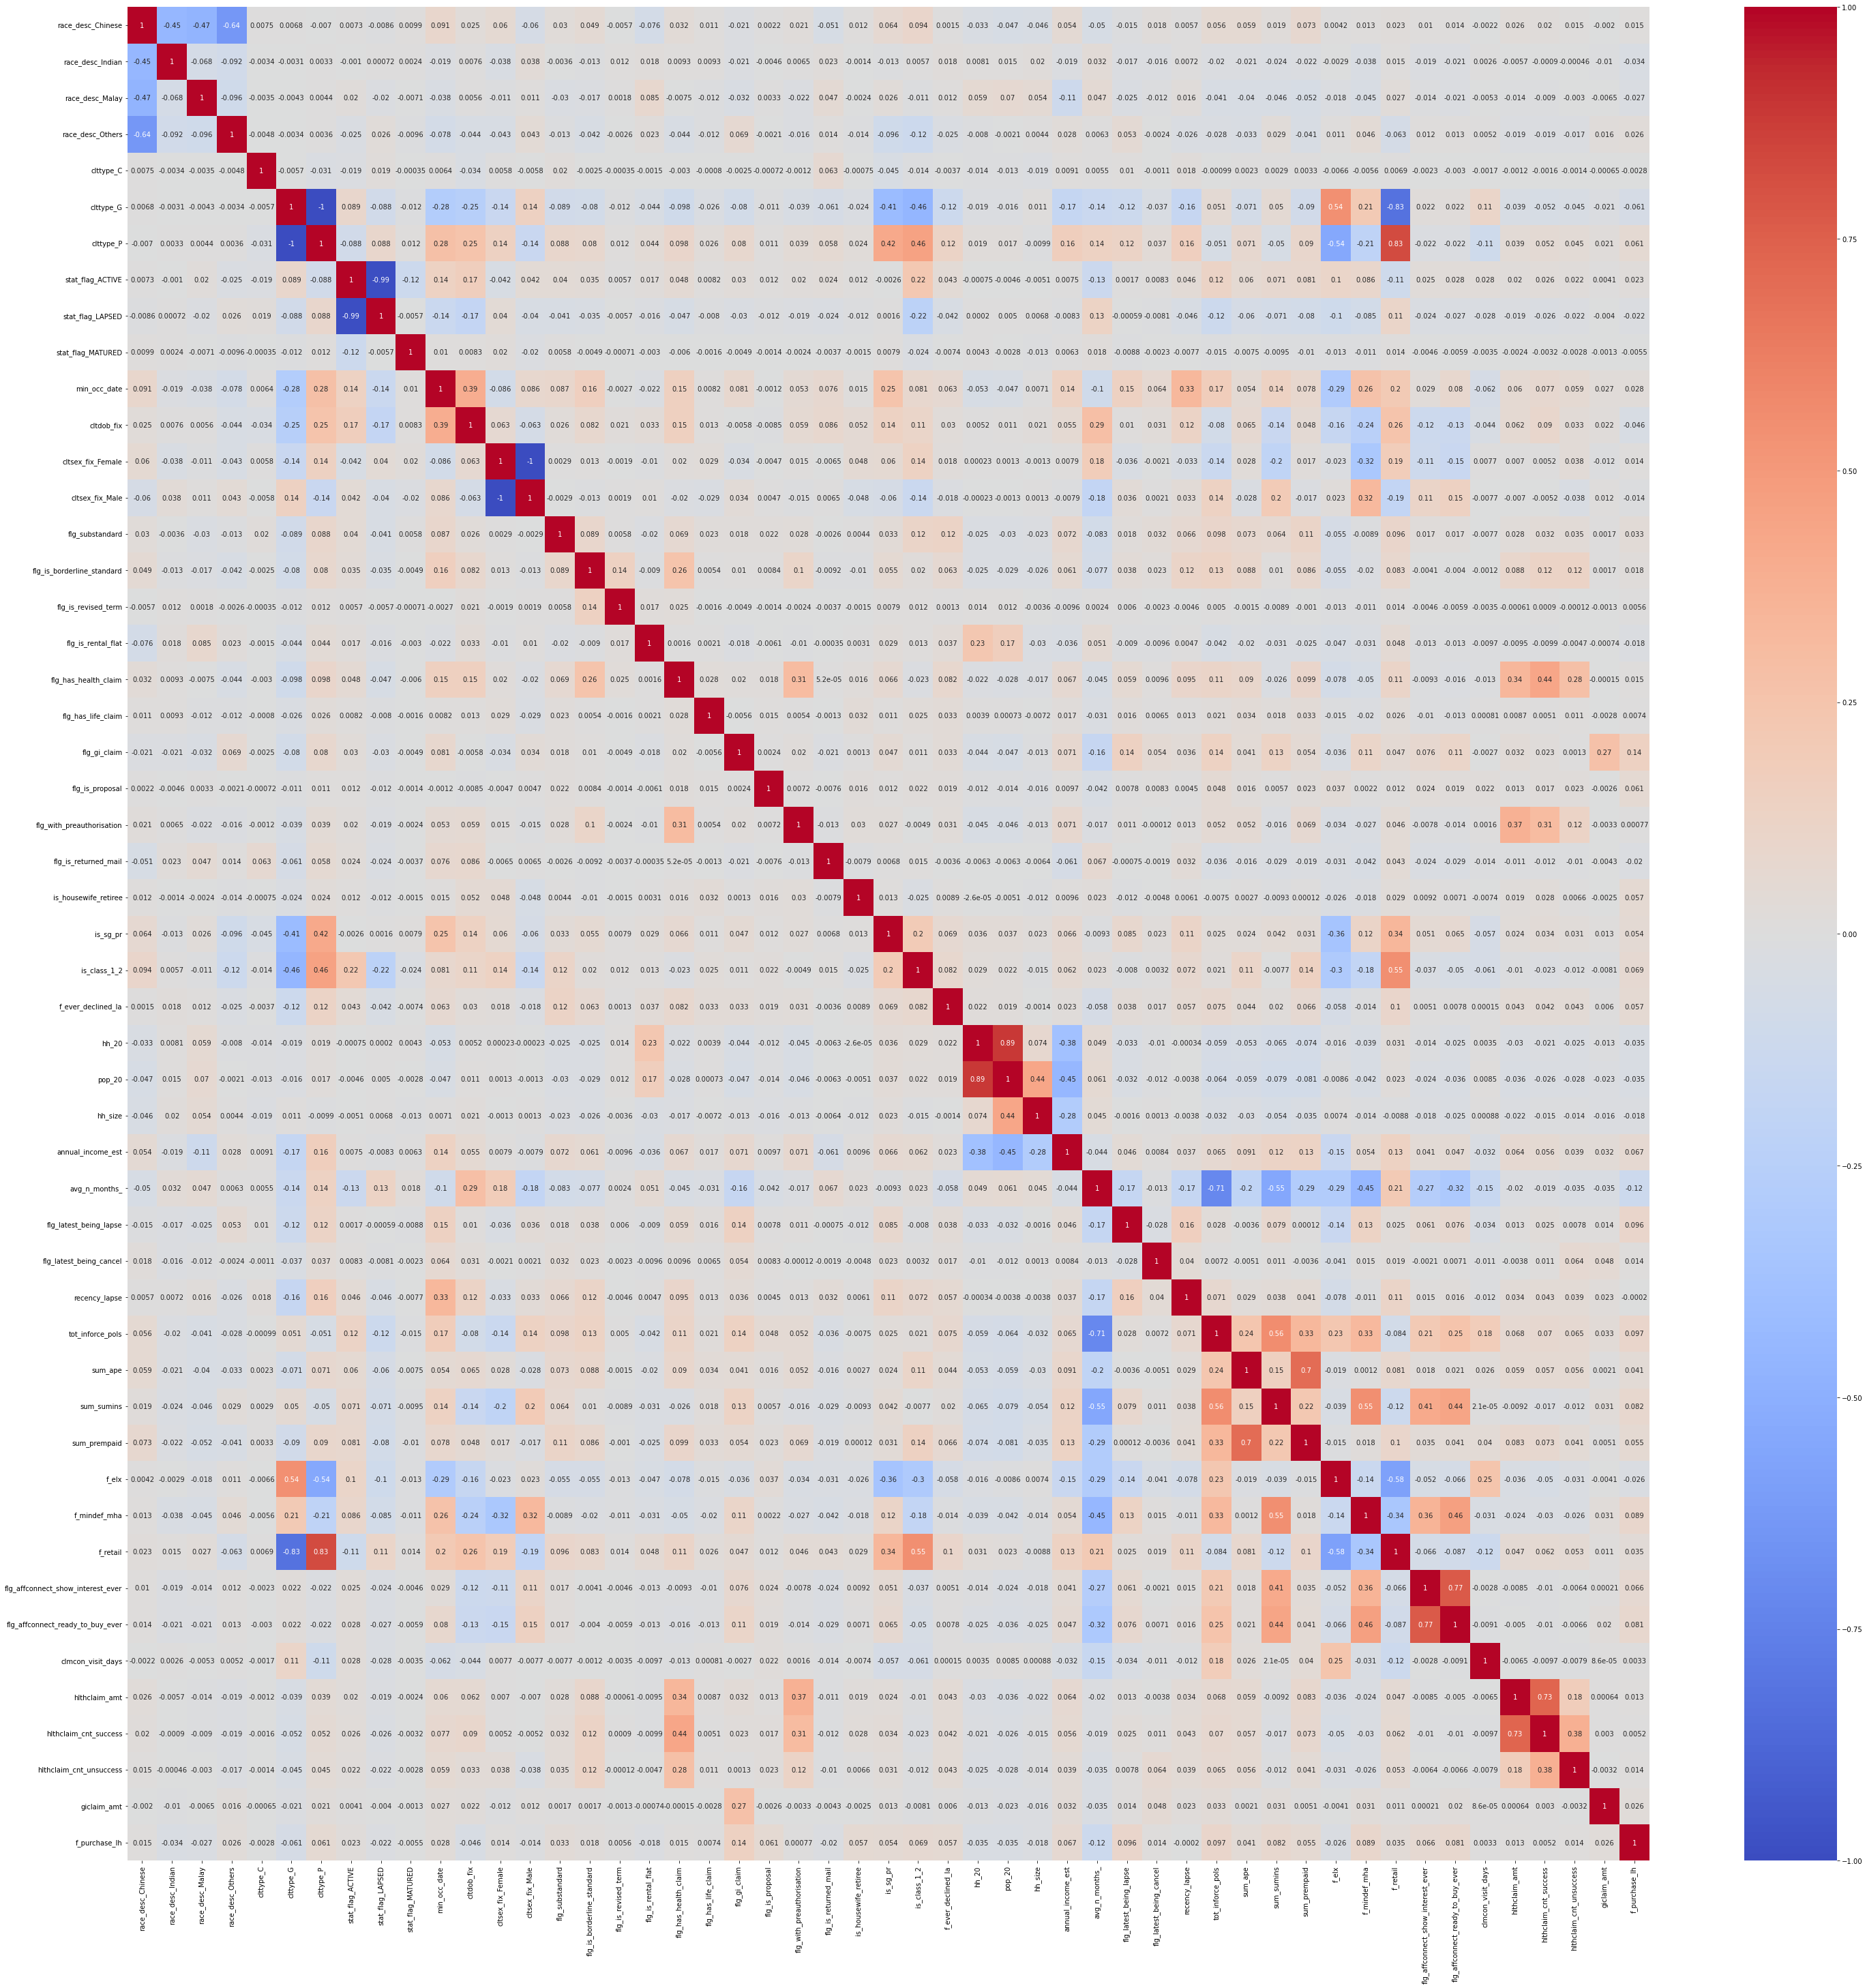

In [22]:
# Print heatmap of correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(50, 50))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

##### Histogram for each column

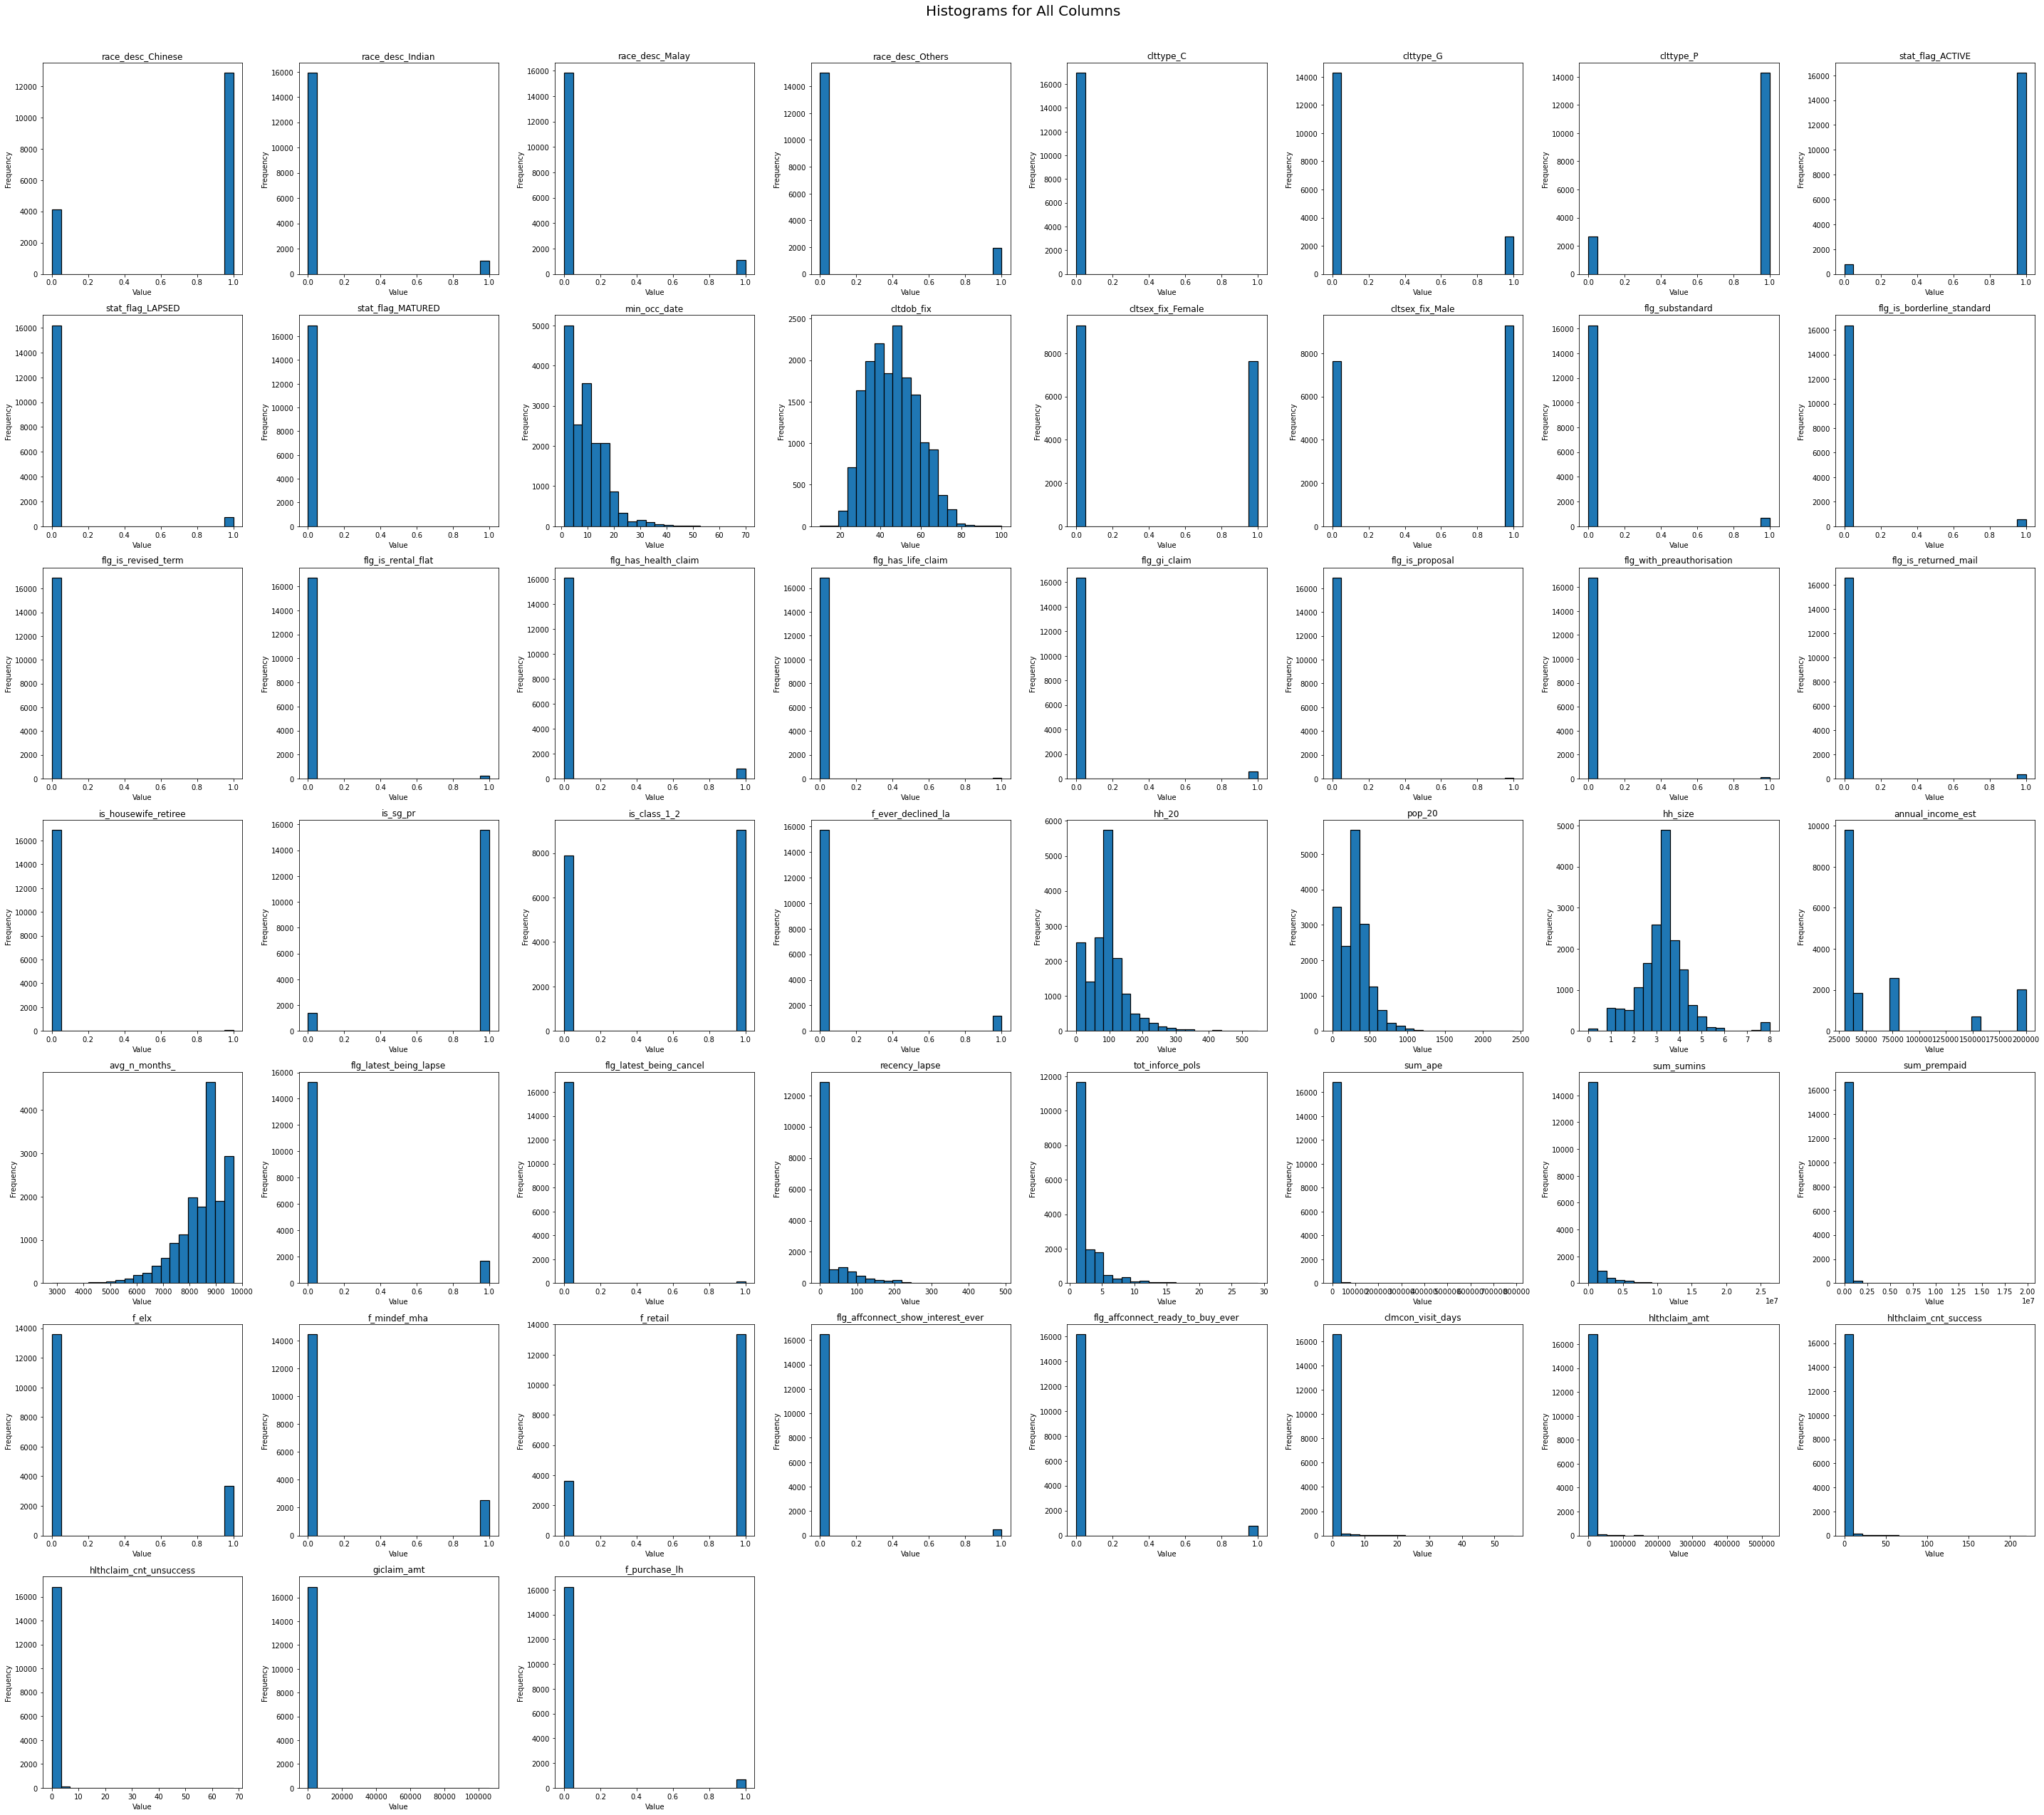

In [23]:
num_cols = len(df.columns)
num_rows = (num_cols // 8) + 1

# Create subplots
fig, axes = plt.subplots(num_rows, 8, figsize=(40, num_rows*5), facecolor='white')
fig.suptitle('Histograms for All Columns', y=1.01, fontsize=20)

# Flatten the axes array
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=20, edgecolor='black', linewidth=1.2)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for i in range(num_cols, num_rows * 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Some Business Insights

##### 1. Low Insurance Purchase in the Past 3 Months:
The data suggests that the number of customers who have purchased insurance in the past 3 months is significantly lower than those who haven't. This might indicate a potential opportunity for Singlife to explore marketing strategies or incentives to encourage more customers to buy insurance within this time frame. Understanding the reasons behind this trend could help in designing targeted campaigns.

##### 2. Most of the insurance bought are personal insurnace labeled as 'dttype_P':
The majority of insurance purchases are categorized as personal insurance ('dttype_P'). This insight indicates a strong preference or demand for personal insurance among customers. Singlife could leverage this information to further tailor and enhance their personal insurance products to meet the specific needs and preferences of their customer base.

##### 3. The proportion of Indian, Malay and others are much less than Chinese:
The data reveals that the proportion of customers from Indian, Malay, and other ethnicities is significantly lower compared to Chinese customers. This could be an area of exploration for Singlife to diversify their customer base by understanding and addressing the specific needs and preferences of customers from different ethnic backgrounds.

##### 4. The customer's age distribution is roughly normal, with the mean around 40, we can see that the customers below 30 are much less:
The age distribution of customers appears to be roughly normal, with a mean around 40. However, there's a noticeable decline in the number of customers below 30. Singlife could consider developing products or marketing strategies that specifically target younger customers, as they represent a potential untapped market.

##### 5. There is about a 50-50 split with customers who are in class 1 and 2 vs those who are not:
There seems to be an approximately 50-50 split between customers in class 1 and 2 compared to those in other classes. While as students, we do not know what class 1 and 2 means here, but understanding the characteristics and preferences of customers in these classes can help Singlife tailor their products to better meet the needs of these specific customer segments.

##### 6. Left Skewed Annual Income Distribution:
The annual income distribution is highly skewed to the left, with a median below $50,000. This suggests that the majority of customers are not high-income earners. Singlife could design insurance products that are affordable and provide value to customers with lower incomes, potentially expanding their market reach.

##### 7. Most of the customers only have 1 policy:
Customers with in-force policies are predominantly those with 1 policy, and very few customers have more than 5 policies. Singlife could explore strategies to encourage existing customers to purchase additional policies, such as offering bundled products or discounts for multiple policies.

##### 8. Most of the customers do not buy any insurance in the past 3 months:
Reiterating the initial insight, the low number of customers who bought insurance in the past 3 months highlights a potential area for growth. Singlife could conduct further market research to understand the reasons behind this trend and design products or campaigns that address customer concerns and encourage them to purchase insurance.

##### Remove columns that have <0.01 correlation with target variable

In [24]:
# Select columns with correlation between -0.01 and 0.01 with 'f_purchase_lh'
selected_columns = df.columns[(
    df.corr()['f_purchase_lh'] > -0.01) & (df.corr()['f_purchase_lh'] < 0.01)].tolist()

print(selected_columns)

# Exclude 'f_purchase_lh' itself from the list if it's present
if 'f_purchase_lh' in selected_columns:
    selected_columns.remove('f_purchase_lh')

df = df.drop(selected_columns, axis=1)
df.shape

['clttype_C', 'stat_flag_MATURED', 'flg_is_revised_term', 'flg_has_life_claim', 'flg_with_preauthorisation', 'recency_lapse', 'clmcon_visit_days', 'hlthclaim_cnt_success']


(16950, 43)

##### Sanity Check

In [25]:
def check_int_float_values(df, include_list=['int', 'float']):
    # Select only integer and float columns
    selected_df = df.select_dtypes(include=include_list)

    # Compare selected columns with original DataFrame columns
    if set(selected_df.columns) != set(df.columns):
        non_int_float_columns = set(df.columns) - set(selected_df.columns)
        raise ValueError(
            f"Non-integer/float values found in columns: {', '.join(non_int_float_columns)}")
    else:
        print("Success: All values in DataFrame are integers or floats.")


def check_missing_values(df):
    # Find columns with missing values
    missing_columns = df.columns[df.isna().any()].tolist()

    # Check if there are any missing columns
    if missing_columns:
        print(f"Missing values found in columns: {', '.join(missing_columns)}")
        raise ValueError(
            f"Missing values found in columns: {', '.join(missing_columns)}")
    else:
        print("Success: No missing values found in DataFrame.")


check_int_float_values(df)
check_missing_values(df)

Success: All values in DataFrame are integers or floats.
Success: No missing values found in DataFrame.


In [26]:
# Check df shape
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 16950
Number of columns: 43


# 2. Modelling (30%)

### 2.1. Handling Imbalanced Data

#### Technique used:
SMOTE

#### Effectiveness and Impact:
This approach has proven empirically to improve the predictive performance of classifiers compared to undersampling the majority class or oversampling the minority class.

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


def print_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    print(f"{dataset_name} Set:\t Accuracy: {accuracy:.2f},\t F1: {f1:.2f}, Recall: {recall:.2f},\t Precision: {precision:.2f}")


def print_confusion_matrix(y_true, y_pred, dataset_name):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {dataset_name} Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Split data into train, dev, and test sets (e.g., 60%, 20%, 20%)

df_decisions = df.copy()

X = df_decisions.drop('f_purchase_lh', axis=1)
y = df_decisions['f_purchase_lh']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, random_state=42)

smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("number of rows after SMOTE: ", X_train_smote.shape[0])
y_train_smote.value_counts()

number of rows after SMOTE:  19524


f_purchase_lh
0.0    13016
1.0     6508
Name: count, dtype: int64

In [29]:
# Data Preprocessing
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import torch.nn.functional as F

# Data Precessing: normalisaiton and convertion to pytorch tensor
scaler = StandardScaler()
pca = PCA(n_components=15)

x_train_smote_scaled = scaler.fit_transform(X_train_smote)
x_dev_scaled = scaler.transform(X_dev)
x_test_scaled = scaler.transform(X_test)

X_train_smote_pca = pca.fit_transform(x_train_smote_scaled)
X_dev_pca = pca.transform(x_dev_scaled)
X_test_pca = pca.transform(x_test_scaled)

x_train_tensor = torch.tensor(X_train_smote_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_dev_tensor = torch.tensor(X_dev_pca, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev.values, dtype=torch.long)
x_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_1=32, hidden_size_2=16, num_classes=2, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size_1),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_size_1, num_classes)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


# Create the model
input_size = X_train_smote_pca.shape[1]

# Modify this based on your y_train shape
num_classes = y_train_tensor.shape[0]
model = NeuralNetwork(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Training loop
num_epochs = 15  # minus one
train_losses = []
dev_losses = []
test_losses = []
train_f1_scores = []
dev_f1_scores = []
test_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    # Calculate F1 score
    with torch.no_grad():
        # Training metrics
        outputs = model(x_train_tensor)
        train_loss = criterion(outputs, y_train_tensor).item()
        _, predicted = torch.max(outputs.data, 1)
        train_f1 = f1_score(y_train_tensor, predicted, average='macro')
        train_losses.append(train_loss)
        train_f1_scores.append(train_f1)

        # Development metrics
        outputs = model(x_dev_tensor)
        dev_loss = criterion(outputs, y_dev_tensor).item()
        _, predicted = torch.max(outputs.data, 1)
        dev_f1 = f1_score(y_dev_tensor, predicted, average='macro')
        dev_losses.append(dev_loss)
        dev_f1_scores.append(dev_f1)

        # Test metrics
        outputs = model(x_test_tensor)
        test_loss = criterion(outputs, y_test_tensor).item()
        _, predicted = torch.max(outputs.data, 1)
        test_f1 = f1_score(y_test_tensor, predicted, average='macro')
        test_losses.append(test_loss)
        test_f1_scores.append(test_f1)

In [31]:
## save the model 
# torch.save(model, 'trained_model.pth')

### 2.2 Choice of Model

### 1. **Model Fit and Justification:**

- **Feature Interactions:** FCNNs are well-suited for tasks where complex interactions between features need to be learned. In the provided dataset, there are various client-related features like demographic information, policy history, and claim metrics. A FCNN can effectively capture intricate relationships among these features which might be crucial for predicting future insurance purchases.

- **Non-Linearity:** The data likely contains non-linear relationships, especially in variables like income, policy history, or demographic features. FCNNs, with their non-linear activation functions, are adept at modeling these non-linearities.

- **Versatility and Adaptability:** FCNNs are known for their adaptability to a wide range of data types and structures. This makes them a good candidate for datasets with a mix of categorical and numerical data, as is the case here.

### 2. **Complexity vs Performance:**

- **Balance Between Complexity and Performance:** FCNNs offer a good balance between model complexity and performance. They are less complex and computationally expensive compared to other deep learning models like convolutional neural networks (CNNs) or recurrent neural networks (RNNs), especially when dealing with tabular data.

- **Scalability:** If the dataset size increases, FCNNs can be scaled up by adding more layers or neurons, allowing them to handle more complex patterns without a significant increase in computational requirements.

- **Overfitting Control:** With techniques like dropout and regularization, FCNNs can be prevented from overfitting, which is crucial given the diverse and possibly high-dimensional nature of the dataset.

### 3. **Data Suitability:**

- **Tabular Data:** FCNNs are particularly well-suited for tabular data, which seems to be the format of the Singlife dataset. They can efficiently process and learn from the structured format of such data.

- **High Dimensionality:** The dataset includes a wide range of variables, indicating high dimensionality. FCNNs are capable of handling high-dimensional data, especially when techniques like dimensionality reduction (e.g., PCA) are applied as a preprocessing step.

- **Diverse Feature Types:** The dataset contains a mix of continuous, categorical, and binary variables. FCNNs can handle this diversity by learning appropriate representations for different types of data.

### 4. **General Considerations:**

- **Rapid Development and Deployment:** The availability of robust frameworks and libraries for neural networks facilitates rapid development, testing, and deployment of FCNNs, accelerating the move from model development to application.

# 3. Performance (10%)

### 3.1 Model Performance Evaluation
Precision Metric, Recall Metric, Balance and Context Relevance

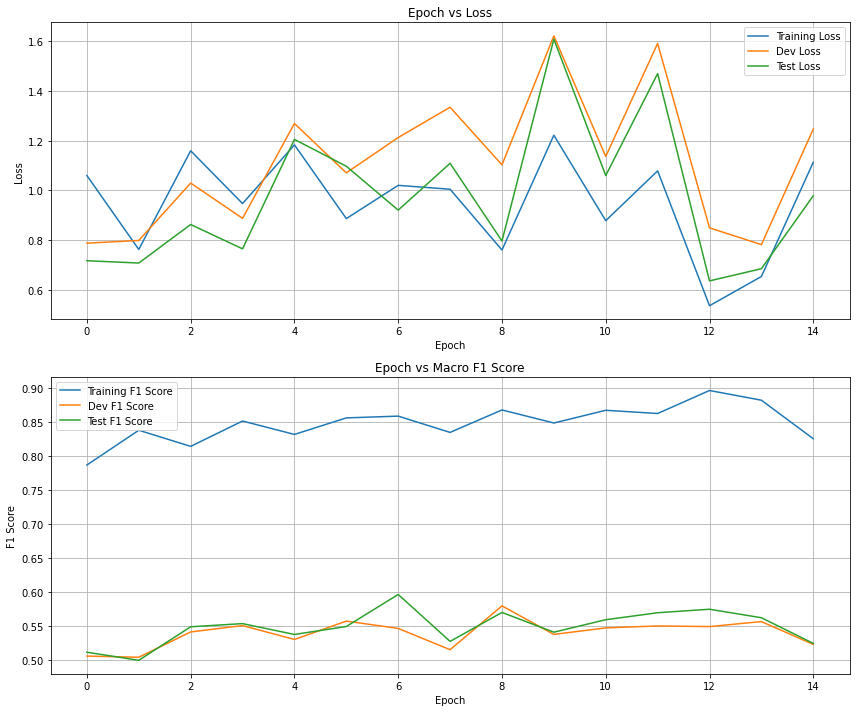

In [32]:
# Evaluating
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), dev_losses, label='Dev Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(2, 1, 2)
plt.plot(range(num_epochs), train_f1_scores, label='Training F1 Score')
plt.plot(range(num_epochs), dev_f1_scores, label='Dev F1 Score')
plt.plot(range(num_epochs), test_f1_scores, label='Test F1 Score')
plt.title('Epoch vs Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training Set Set:	 Accuracy: 0.85,	 F1: 0.83, Recall: 0.74,	 Precision: 0.79
Development Data Set:	 Accuracy: 0.86,	 F1: 0.52, Recall: 0.21,	 Precision: 0.09
Test Data Set:	 Accuracy: 0.86,	 F1: 0.52, Recall: 0.25,	 Precision: 0.09


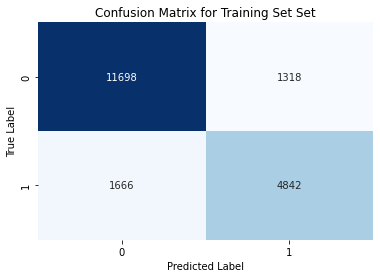

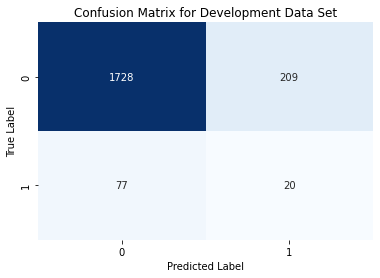

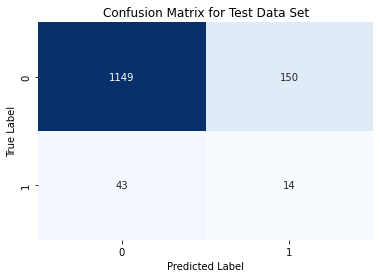

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Function to calculate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model, x_tensor, y_tensor, title):
    with torch.no_grad():
        outputs = model(x_tensor)
        _, predicted = torch.max(outputs.data, 1)
        print_confusion_matrix(y_tensor.numpy(), predicted.numpy(), title)

# Function to calculate and print metrics
def evaluate_metric(model, x_tensor, y_tensor, title):
    with torch.no_grad():
        outputs = model(x_tensor)
        _, predicted = torch.max(outputs.data, 1)
        print_metrics(y_tensor.numpy(), predicted.numpy(), title)


# Use these functions in your code
evaluate_metric(model, x_train_tensor, y_train_tensor, 'Training Set')
evaluate_metric(model, x_dev_tensor, y_dev_tensor, 'Development Data')
evaluate_metric(model, x_test_tensor, y_test_tensor, 'Test Data')

evaluate_and_plot_confusion_matrix(
    model, x_train_tensor, y_train_tensor, 'Training Set')
evaluate_and_plot_confusion_matrix(
    model, x_dev_tensor, y_dev_tensor, 'Development Data')
evaluate_and_plot_confusion_matrix(
    model, x_test_tensor, y_test_tensor, 'Test Data')

# ----- End of Datathon ----- #

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

##### Helper Functions for final submission

In [34]:
import numpy as np
import pandas as pd


def replace_missing_with_zero(df, column_name):
    df[column_name].fillna(0, inplace=True)
    return df


def replace_missing_with_one(df, column_name):
    df[column_name].fillna(1, inplace=True)
    return df


def replace_missing_with_median(df, column_name):
    median_value = df[column_name].median()
    df[column_name].fillna(median_value, inplace=True)
    return df


def value_proportions(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    total_count = arr.size
    proportions = counts / total_count
    return dict(zip(unique_values, proportions))


def fill_missing_with_proportions(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Get the non-missing values and their proportions
    non_missing_values = df[column_name].dropna()
    value_distribution = value_proportions(non_missing_values)

    # Convert the value distribution into two lists for np.random.choice
    values, probabilities = zip(*value_distribution.items())

    # Count the missing values
    missing_count = df[column_name].isna().sum()

    if missing_count > 0:
        # Generate random samples based on the value distribution
        random_samples = np.random.choice(
            values, size=missing_count, p=probabilities)

        # Fill in the missing values with these random samples
        df.loc[df[column_name].isna(), column_name] = random_samples

    return df


def delete_rows_with_all_missing(df, columns_names):
    # Initial number of rows
    initial_row_count = len(df)

    # Drop rows where all values in the selected columns are missing
    df = df.dropna(subset=columns_names, how='all')

    # Calculate the number of rows deleted
    deleted_rows_count = initial_row_count - len(df)

    return df


def find_col_index(df, col_name):
    return df.columns.get_loc(col_name)


def one_hot_encode(df, col, start_position=0):
    df_encoded = pd.get_dummies(df[col], prefix=col, dtype=int)
    df.drop(col, axis=1, inplace=True)
    df = pd.concat([df.iloc[:, :start_position], df_encoded,
                   df.iloc[:, start_position:]], axis=1)
    return df


def years_until_2024(df, column_name, target_year=2024):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Remove rows where the date column is "None"
    df = df[df[column_name] != "None"]

    # Strip the string of whitespace and convert to datetime using .loc
    df.loc[:, column_name] = pd.to_datetime(
        df[column_name].str.strip(), format='%Y-%m-%d', errors='raise')

    # Calculate the number of years until 2024 using .loc
    df.loc[:, column_name] = df[column_name].apply(
        lambda x: target_year - x.year if pd.notnull(x) else None)

    # Convert the column to integer data type
    df = df.astype({column_name: 'int64'})

    return df


def fetch_all_columns_with_prefix(df, prefix):
    # Get all the columns that start with the prefix
    cols_to_fetch = df.columns[df.columns.str.startswith(prefix)]

    return cols_to_fetch.tolist()


def sum_numeric_columns_prefix(df, prefix, new_column_name='sum', start_position=0):
    # Get all the columns that start with the prefix
    column_names = fetch_all_columns_with_prefix(df, prefix)

    # Convert columns to numeric
    for col in column_names:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='raise')
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Sum the columns
    df[new_column_name] = df[column_names].sum(axis=1)

    # Insert the new column at the specified start_position index
    df = pd.concat([df.iloc[:, :start_position],
                   df[new_column_name], df.iloc[:, start_position:-1]], axis=1)

    # Drop the original columns
    df = df.drop(column_names, axis=1)

    return df


def average_numeric_columns(df, prefix, new_columns_name='average', start_position=0):
    # Get all the columns that start with the prefix
    column_names = fetch_all_columns_with_prefix(df, prefix)

    # Convert columns to numeric
    for col in column_names:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='raise')
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    # Sum the columns
    df[new_columns_name] = df[column_names].mean(axis=1).round(2)

    # Insert the new column at the specified start_position index
    df = pd.concat([df.iloc[:, :start_position],
                   df[new_columns_name], df.iloc[:, start_position:-1]], axis=1)

    df = df.drop(column_names, axis=1)

    return df

# --- End of Micro Helper Functions ---


def data_cleaning(df):
    df = df.copy()
    # --- Drop 100% missing columns ---
    cols_missing = df.columns[df.isnull().sum() > 0]
    cols_missing_all = df.columns[df.isnull().sum() == df.shape[0]]
    cols_missing_100 = cols_missing.intersection(cols_missing_all)
    df.drop(cols_missing_100, axis=1, inplace=True)

    # --- Replace missing values with 0 ---
    columns_to_replace_missing_with_zero = ['f_ever_declined_la', 'recency_lapse', 'flg_affconnect_show_interest_ever',
                                            'flg_affconnect_ready_to_buy_ever', 'clmcon_visit_days', 'hlthclaim_amt',
                                            'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'giclaim_amt']

    for i in columns_to_replace_missing_with_zero:
        df = replace_missing_with_zero(df, i)

    # --- Replace missing values with 1 ---
    columns_to_replace_missing_with_one = ['is_dependent_in_at_least_1_policy']

    for i in columns_to_replace_missing_with_one:
        df = replace_missing_with_one(df, i)

    # --- Replace missing values with median ---
    columns_to_replace_missing_with_median = [
        'hh_20', 'pop_20', 'hh_size']

    for i in columns_to_replace_missing_with_median:
        df = replace_missing_with_median(df, i)

    # --- Fill missing values according to proportion of missing values in each column ---
    df = fill_missing_with_proportions(df, 'race_desc')
    df = fill_missing_with_proportions(df, 'cltsex_fix')

    # --- Delete rows with continuous missing values about flg_* columns ---
    SELECTED_FLG_COLUMNS = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
                            'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
                            'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation',
                            'flg_is_returned_mail']
    df = delete_rows_with_all_missing(df, SELECTED_FLG_COLUMNS)

    return df


def feature_selection(df):
    df = df.copy()
    # --- Drop 'clntnum' column ---
    df.drop('clntnum', axis=1, inplace=True)

    # --- Drop columns that have no missing values and one unique value ---
    cols_no_missing = df.columns[df.isnull().sum() == 0]
    cols_one_unique = df.columns[df.nunique() == 1]
    cols_to_drop = cols_no_missing.intersection(cols_one_unique)
    df.drop(cols_to_drop, axis=1, inplace=True)

    # --- Drop more cols ---
    COMMUNICATION_PREFERENCE_COLS = [
        'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email'
    ]
    DROP_COLS = [
        'ctrycode_desc', *COMMUNICATION_PREFERENCE_COLS, 'hh_size_est', 'recency_cancel', 'tot_cancel_pols', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis',
        'recency_hlthclaim', 'recency_hlthclaim_success', 'recency_hlthclaim_unsuccess', 'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a', 'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb37',
        'recency_giclaim'
    ]
    DROP_COLS_REGEX = ['lapse_ape_*', 'n_months_since_lapse_*',
                       'f_hold_*', 'f_ever_bought_*']

    df.drop(DROP_COLS, axis=1, inplace=True)
    cols_to_drop = df.columns[df.columns.str.contains(
        '|'.join(DROP_COLS_REGEX))]
    df.drop(cols_to_drop, axis=1, inplace=True)

    return df


def feature_engineering(df):
    df = df.copy()
    # --- Change 'annual_income_est' from string to integer ---
    for index, row in df.iterrows():
        if row['annual_income_est'] == 'A.ABOVE200K':
            df.loc[index, 'annual_income_est'] = 200000
        elif row['annual_income_est'] == 'B.100K-200K':
            df.loc[index, 'annual_income_est'] = 150000
        elif row['annual_income_est'] == 'C.60K-100K':
            df.loc[index, 'annual_income_est'] = 80000
        elif row['annual_income_est'] == 'D.30K-60K':
            df.loc[index, 'annual_income_est'] = 45000
        elif row['annual_income_est'] == 'E.BELOW30K':
            df.loc[index, 'annual_income_est'] = 30000

    # Fill nan of annual_income_est with median
    df = replace_missing_with_median(df, 'annual_income_est')

    # --- Do One Hot Encoding for categorical variables ---
    # One hot encoding for 'clttype'
    start_position = find_col_index(df, 'clttype')
    df = one_hot_encode(df, 'clttype', start_position)

    # One hot encoding for 'stat_flag'
    start_position = find_col_index(df, 'stat_flag')
    df = one_hot_encode(df, 'stat_flag', start_position)

    # One hot encoding for 'race_desc'
    start_position = find_col_index(df, 'race_desc')
    df = one_hot_encode(df, 'race_desc', start_position)

    # One hot encoding for 'cltsex_fix'
    start_position = find_col_index(df, 'cltsex_fix')
    df = one_hot_encode(df, 'cltsex_fix', start_position)

    # --- Convert dates to years ---
    df = years_until_2024(df, 'min_occ_date', 2024)
    df = years_until_2024(df, 'cltdob_fix', 2024)

    # --- Sum/Average columns of interest to create new columns ---
    start_position = find_col_index(
        df, fetch_all_columns_with_prefix(df, 'ape_')[0])
    df = sum_numeric_columns_prefix(df, 'ape_', 'sum_ape', start_position)

    start_position = find_col_index(
        df, fetch_all_columns_with_prefix(df, 'sumins_')[0])
    df = sum_numeric_columns_prefix(
        df, 'sumins_', 'sum_sumins', start_position)

    start_position = find_col_index(
        df, fetch_all_columns_with_prefix(df, 'prempaid_')[0])
    df = sum_numeric_columns_prefix(
        df, 'prempaid_', 'sum_prempaid', start_position)

    start_position = find_col_index(
        df, fetch_all_columns_with_prefix(df, 'n_months_')[0])
    df = average_numeric_columns(
        df, 'n_months_', 'avg_n_months_', start_position)

    # --- Check for columns that should be in int or float ---
    df = df.astype({'hh_20': 'int64', 'pop_20': 'int64',
                    'hlthclaim_amt': 'float', 'giclaim_amt': 'float'})

    # --- Remove columns that have <0.01 correlation with target variable ---
    columns_less = ['clttype_C', 'stat_flag_MATURED', 'flg_is_revised_term', 'flg_has_life_claim',
                    'flg_with_preauthorisation', 'recency_lapse', 'clmcon_visit_days', 'hlthclaim_cnt_success']

    df.drop(columns_less, axis=1, inplace=True)

    return df


def preprocessing_data_analysis(df):
    df = df.copy()
    # --- Data cleaning ---
    df = data_cleaning(df)
    print("After data cleaning", df.shape)

    # --- Feature selection ---
    df = feature_selection(df)
    print("After feature selection", df.shape)

    # --- Feature engineering ---
    df = feature_engineering(df)
    print("After feature engineering", df.shape)

    return df

def preprocessing_model(hidden_data, scalar=scaler, pca=pca):
    x_test_hidden_data = scalar.transform(hidden_data)
    x_test_hidden_data = pca.transform(x_test_hidden_data)
    x_test_hidden_data = torch.tensor(x_test_hidden_data, dtype=torch.float32)
    
    print("After scaling and PCA, before feeding into the model", x_test_hidden_data.shape)
    return x_test_hidden_data

def predict_output(x_test_hidden_data, model=model):
    with torch.no_grad():
        # Training metric
        return_y = model(x_test_hidden_data)
        _, predicted = torch.max(return_y.data, 1)
        return predicted.tolist()
    
def load_model(filepath):
    model = torch.load(filepath)
    model.eval()
    return model
    
    

In [35]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    # --- Preprocessing based on data analysis ---
    hidden_data = preprocessing_data_analysis(hidden_data) # 42 features
    
    # ---  Preprocessing for model prediction ---
    x_test_hidden_data = preprocessing_model(hidden_data) # 15 features

    # ---  Load model and Predict the output ---
    train_model = load_model("./train_model.pth")
    result = predict_output(x_test_hidden_data, train_model)
    
    return result

##### Cell to check testing_hidden_data function

In [36]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

After data cleaning (16978, 295)
After feature selection (16978, 139)


/var/folders/ms/9mlzst3s2vj4lsly34ghl8900000gn/T/ipykernel_55872/729502146.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[column_names].sum(axis=1)


After feature engineering (16950, 42)
After scaling and PCA, before feeding into the model torch.Size([16950, 15])
[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!